Diagnosing ALL with machine learning

Import desired libraries and connect to storage.

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import numpy as np
import pandas as pd
from PIL import Image
from os import listdir
from os.path import isfile, join

Classes to transform images to adjust contrast and rgb values

In [4]:
class ContrastAdjustmentTransform:
    """Adjust contrast across all channels equally."""

    def __init__(self, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax

    def __call__(self, x):
        # convert from expected uint8 PIL image type to float numpy array and scale to 0-1 range
        x = np.asarray(x).astype(float)/255.0

        # apply contrast adjustment
        x = (x - self.xmin)/(self.xmax - self.xmin)

        # saturate values 
        x[x < 0] = 0
        x[x > 1] = 1
        
        # scale back to 0-255, convert to uint8, and return as PIL image
        x *= 255
        x = x.astype(np.uint8)
        return Image.fromarray(x)
    
class ContrastAdjustmentTransformRGB:
    """Adjust contrast for each channel independently based on given limits."""

    def __init__(self, xmin_list, xmax_list):
        self.xmin_list = xmin_list
        self.xmax_list = xmax_list

    def __call__(self, x):
        # convert from expected uint8 PIL image type to float numpy array and scale to 0-1 range
        x = np.asarray(x).astype(float)/255.0

        # apply contrast adjustment (to each channel independently)
        for channel in range(0,3):
            x[:,:,channel] = (x[:,:,channel]  - self.xmin_list[channel])/(self.xmax_list[channel] - self.xmin_list[channel])

        # saturate values
        x[x < 0] = 0
        x[x > 1] = 1

        # scale back to 0-255, convert to uint8, and return as PIL image
        x *= 255
        x = x.astype(np.uint8)
        return Image.fromarray(x)

Image transformation

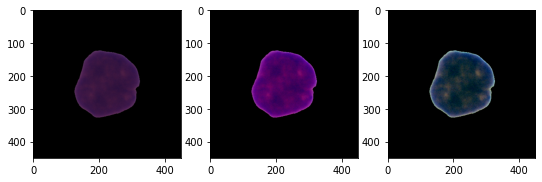

In [5]:
image_filenames = [f for f in listdir('/content/drive/MyDrive/C-NMC_Leukemia/training_data/all') if isfile(join('/content/drive/MyDrive/C-NMC_Leukemia/training_data/all', f))]

filename = image_filenames[np.random.randint(0,len(image_filenames))]

example_image = Image.open('/content/drive/MyDrive/C-NMC_Leukemia/training_data/all/' + filename)

contrast_adjust = ContrastAdjustmentTransform(0.1,0.5)
example_image_adjusted = contrast_adjust(example_image)

contrast_adjust_rgb = ContrastAdjustmentTransformRGB([0.2, 0.05, 0.2],[0.45, 0.25, 0.45])
example_image_adjusted_rgb = contrast_adjust_rgb(example_image)


fig, ax = plt.subplots(figsize=(9,3),ncols=3)
ax[0].imshow(example_image) 
ax[1].imshow(example_image_adjusted)
ax[2].imshow(example_image_adjusted_rgb)
plt.show()

Load dataset

In [6]:
batch_size = 20

xmin_list = [0.2, 0.05, 0.2]
xmax_list = [0.45, 0.25, 0.45]

def get_data():
    data_dir = '/content/drive/MyDrive/C-NMC_Leukemia/'

    transform_train = transforms.Compose([
        transforms.CenterCrop(384),
        # ContrastAdjustmentTransform(0.15,0.45),
        ContrastAdjustmentTransformRGB(xmin_list,xmax_list),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor()])


    transform_test = transforms.Compose([
        transforms.CenterCrop(384),
        transforms.Resize(128),
        # ContrastAdjustmentTransform(0.15,0.45),
        ContrastAdjustmentTransformRGB(xmin_list,xmax_list),
        transforms.ToTensor(),
        ])
    
    data_set = datasets.ImageFolder(data_dir + '/training_data', transform=transform_train)

    N_data = len(data_set)
    # print('length of dataset:'N_data)
    N_subset = int(0.3*N_data)
    N_train = int(0.75*N_subset)
    print('length of training data:', N_train)
    N_test = N_subset - N_train
    print('lenfth of testing data:', N_test)
    N_leftover = N_data - N_subset
    print('length of leftover data:', N_leftover)
    data_set_train, data_set_test, _  = torch.utils.data.random_split(dataset=data_set, lengths=[N_train, N_test, N_leftover], generator=torch.Generator().manual_seed(42))

    train = DataLoader(data_set_train, batch_size=batch_size, shuffle=True)
    test = DataLoader(data_set_test, batch_size=batch_size, shuffle=False)

    return train, test


In [7]:
train, test = get_data()

length of training data: 2398
lenfth of testing data: 800
length of leftover data: 7463


In [8]:
# note the the length of the train does not tell us how many images are in train,
# rather the number of images per batch

Show transformed images

In [9]:
def train_imshow():
    classes = ('all', 'hem') # Defining the classes we have
    dataiter = iter(train)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(figsize=(12, 6), ncols=5)
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0)) 
        ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
    plt.show()


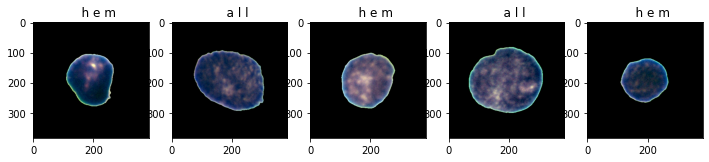

In [10]:
train_imshow()

In [11]:
import torchvision.models as models

Define model and convolutional layers

In [12]:
class Net(nn.Module):
  def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(3, 64, 3)
      self.pool = nn.MaxPool2d(8, 8)
      self.conv2 = nn.Conv2d(64, 128, 3)
      self.fc1 = nn.Linear(128, 1024)
      self.fc2 = nn.Linear(1024, 32)
      self.fc3 = nn.Linear(32, 2)

  def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 128)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      x = F.softmax(x)
      return x

In [13]:
# model = Net()
freeze_backbone = False
use_max_pooling = True

model = models.efficientnet_b3(pretrained=True)

if use_max_pooling:
    maxpools = [k.split('.') for k, m in model.named_modules() if type(m).__name__ == 'AdaptiveAvgPool2d']
    for *parent, k in maxpools:
        setattr(model.get_submodule('.'.join(parent)),'avgpool',nn.AdaptiveMaxPool2d(output_size=1))

if freeze_backbone:
    for params in model.parameters():
        params.requires_grad = False

model.classifier = nn.Sequential(
    nn.BatchNorm1d(num_features=1536,momentum=0.95),
    nn.Linear(in_features=1536, out_features=256),
    nn.SiLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=256,out_features=2),
    nn.Softmax()
)

# print(model)

summary(model.cuda(),(3, 128, 128))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 64, 64]           1,080
       BatchNorm2d-2           [-1, 40, 64, 64]              80
              SiLU-3           [-1, 40, 64, 64]               0
            Conv2d-4           [-1, 40, 64, 64]             360
       BatchNorm2d-5           [-1, 40, 64, 64]              80
              SiLU-6           [-1, 40, 64, 64]               0
 AdaptiveMaxPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12           [-1, 40, 64, 64]               0
           Conv2d-13           [-1, 24, 64, 64]             960
      BatchNorm2d-14           [-1, 24,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Check if cuda

In [14]:
lr = 0.002
lr_ratio = 0.5
patience = 3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=lr, weight_decay=0)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',patience=patience,factor=lr_ratio)

if torch.cuda.is_available(): # Checking if we can use GPU
    model = model.cuda()
    criterion = criterion.cuda()


Define test for model

In [15]:
def test_epoch():
    correct = 0
    total = 0
    k = 0
    loss_total = 0
    model.eval()
    with torch.no_grad():
        for data in test:
            images, labels = data
            outputs = model(images.cuda())
            _, predicted = torch.max(outputs.data, 1)
            loss_k = criterion(outputs, labels.cuda())
            total_k = labels.size(0)
            total += total_k
            correct_k = np.sum(labels.numpy() == predicted.cpu().numpy())
            correct += correct_k
            k += 1
            loss_total += total_k*loss_k.item()

    test_accuracy = 100*correct/total
    test_loss = loss_total/total

    return test_loss, test_accuracy

Perform training

In [16]:
Lp = 50

n_epoch = 50

epoch_loss_train = np.zeros(n_epoch)
epoch_acc_train = np.zeros(n_epoch)
epoch_loss_test = np.zeros(n_epoch)
epoch_acc_test = np.zeros(n_epoch)
epoch_learning_rate = np.zeros(n_epoch)
acc_test_best = 0
count = 0

N_train_batch = len(train)


for epoch in range(n_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    running_n = 0
    running_acc = 0.0
    for i, data in enumerate(train, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data


      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs.cuda())
      loss = criterion(outputs, labels.cuda())
      loss.backward()
      optimizer.step()

      running_n += len(outputs)

      labels_pred = np.argmax(outputs.cpu().detach().numpy(),axis=1)
      # print(outputs)
      # print(labels)
      # print(labels_pred)
      # print(loss)

      # acc = np.sum(((outputs.cpu().detach().numpy()[:,0] > 0.5) == labels.numpy()))/batch_size
      acc = np.sum(labels_pred == labels.cpu().detach().numpy())
      # print statistics
      running_loss += len(outputs)*loss.item()
      running_acc += acc

      p = int(Lp*((i+1)/N_train_batch))
      s = ['#']*p + ['-']*(Lp - p)
      s = "".join(s)
      print(f'epoch: {epoch:04d} | [{s}] ({int(100*(i+1)/N_train_batch):02d}%)',end='\r')

    loss_test, acc_test = test_epoch()
    model.train()

    scheduler.step(acc_test)

    # if acc_test < acc_test_best:
    #     count += 1
    # else:
    #     acc_test_best = acc_test
    #     count = 0



    # if count >= patience:
    #     lr = lr*lr_ratio
    #     for g in optim.param_groups:
    #         g['lr'] = lr
    #     count = 0

    sched_lr = optimizer.param_groups[0]['lr']

    print(f'epoch: {epoch:04d} | training loss = {running_loss/running_n:0.4f} | training accuracy = {100*running_acc/running_n:0.1f} | test loss = {loss_test:0.4f} | test accuracy = {acc_test:0.1f} | count = {count} | learning rate = {sched_lr}')

    epoch_loss_train[epoch] = running_loss/running_n
    epoch_acc_train[epoch] = 100*running_acc/running_n
    epoch_loss_test[epoch] = loss_test
    epoch_acc_test[epoch] = acc_test
    epoch_learning_rate[epoch] = sched_lr


epoch: 0000 | training loss = 0.6446 | training accuracy = 65.4 | test loss = 0.5994 | test accuracy = 70.4 | count = 0 | learning rate = 0.002
epoch: 0001 | training loss = 0.6142 | training accuracy = 68.9 | test loss = 0.5820 | test accuracy = 72.2 | count = 0 | learning rate = 0.002
epoch: 0002 | training loss = 0.5819 | training accuracy = 71.8 | test loss = 0.5217 | test accuracy = 78.0 | count = 0 | learning rate = 0.002
epoch: 0003 | training loss = 0.5267 | training accuracy = 78.1 | test loss = 0.5093 | test accuracy = 80.0 | count = 0 | learning rate = 0.002
epoch: 0004 | training loss = 0.5158 | training accuracy = 79.3 | test loss = 0.5044 | test accuracy = 80.6 | count = 0 | learning rate = 0.002
epoch: 0005 | training loss = 0.5122 | training accuracy = 79.6 | test loss = 0.5287 | test accuracy = 78.2 | count = 0 | learning rate = 0.002
epoch: 0006 | training loss = 0.4943 | training accuracy = 81.4 | test loss = 0.4802 | test accuracy = 82.9 | count = 0 | learning rate 

Save model

In [17]:
torch.save(model.state_dict(), 'efficientnetb3_leukemia_model.pth')

In [ ]:
import pickle

training_results = {'epoch_loss_train': epoch_loss_train,
    'epoch_acc_train': epoch_acc_train,
    'epoch_loss_test': epoch_loss_test,
    'epoch_acc_test': epoch_acc_test,
    'epoch_learning_rate': epoch_learning_rate}

with open('training_results.pkl', 'wb') as f:
    pickle.dump(training_results, f, protocol=pickle.HIGHEST_PROTOCOL)

Plot results

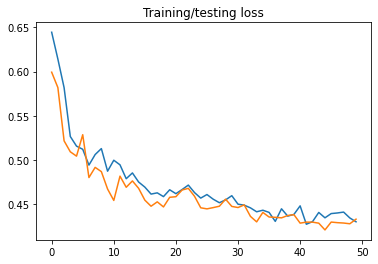

In [18]:
fig, ax = plt.subplots()
ax.plot(np.arange(0,n_epoch), epoch_loss_train, np.arange(0,n_epoch), epoch_loss_test)
ax.set_title('Training/testing loss')
plt.show()

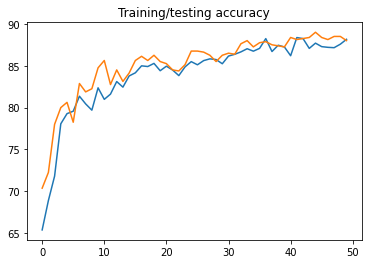

In [19]:
fig, ax = plt.subplots()
ax.plot(np.arange(0,n_epoch), epoch_acc_train, np.arange(0,n_epoch), epoch_acc_test)
ax.set_title('Training/testing accuracy')
plt.show()

Load model

In [22]:
# Loading the trained network
model.load_state_dict(torch.load('efficientnetb3_leukemia_model.pth'))

<All keys matched successfully>